In [23]:
source('helpers.R')

In [8]:
prepost <- readRDS("../../../ProcessedData/seurat/annotated_prepost_csf.rds")

In [9]:
target <- subset(prepost, cell_type %in%  c('CD4+ T', 'CD4+ CAR T', 'CD8+ T', 'CD8+ CAR T', 'Cycling CD8+ T')) 

target$cluster = 'CD8'
target$cluster[target$cell_type %in% c('CD4+ T', 'CD4+ CAR T')] = 'CD4'

target$group_by_cluster = 'CART' 
target$group_by_cluster[target$cell_type %!in% c('CD4+ CAR T', 'CD8+ CAR T')] = 'Endogenous'

target$group_by_transcript = 'CART' 
target$group_by_transcript[target$CAR_Transcript == 'CAR -'] = 'Endogenous'

target$sample = paste0(target$sample_id, '_', target$group_by_cluster)

In [10]:
cd8.target = subset(target, cluster == 'CD8')

cd8.target$Day_Type_CAR = paste0(cd8.target$Day, ' CD8+ ', cd8.target$group_by_cluster)
order = c('D0 CD8+ Endogenous','D7 CD8+ Endogenous','D21 CD8+ Endogenous','D7 CD8+ CART','D21 CD8+ CART')
cd8.target$Day_Type_CAR <- factor(cd8.target$Day_Type_CAR, levels = order)
(table(cd8.target$Day_Type_CAR))


 D0 CD8+ Endogenous  D7 CD8+ Endogenous D21 CD8+ Endogenous        D7 CD8+ CART 
               3514                3799                2644               10856 
      D21 CD8+ CART 
               2274 

In [11]:
sigs = read.csv('../../../Resources/Lowery_Signatures.csv')
marker_genes <- list()

for (i in 1:ncol(sigs)) {
  signature_name <- colnames(sigs)[i]
  gene_names <- sigs[1:nrow(sigs), i]
  gene_names <- gene_names[gene_names != ""]  # Remove empty strings
  marker_genes[[signature_name]] <- gene_names
}

In [19]:
muscat.edgeR <- muscat.de.genes(
    seurat_obj = target, 
    cluster_col = 'cluster', 
    group_col = 'group_by_cluster', 
    sample_col = 'sample', 
    method = 'edgeR'
)

protein_coding <- filter_genes_by_biotype(muscat.edgeR$gene, biotype = "protein_coding")
muscat.edgeR <- muscat.edgeR[muscat.edgeR$gene %in%  c(protein_coding$filtered_genes, 'CAR'),]

cd8.muscat = muscat.edgeR[muscat.edgeR$cluster_id == 'CD8',]
cd8.muscat$logFC <- cd8.muscat$logFC*-1
cd8.muscat <- subset(cd8.muscat, p_adj.glb < 0.05)

  |======================================================================| 100%

    Num DE.genes % DE.genes
CD4         4984       13.6
CD8         5400       14.8


In [20]:
ranks <- cd8.muscat$logFC
names(ranks) <- cd8.muscat$gene
ranks <- sort(ranks, decreasing = TRUE)
pathways <- list(NeoTCR8 = marker_genes$NeoTCR8)
fgseaRes <- fgsea(pathways = pathways, stats = ranks)

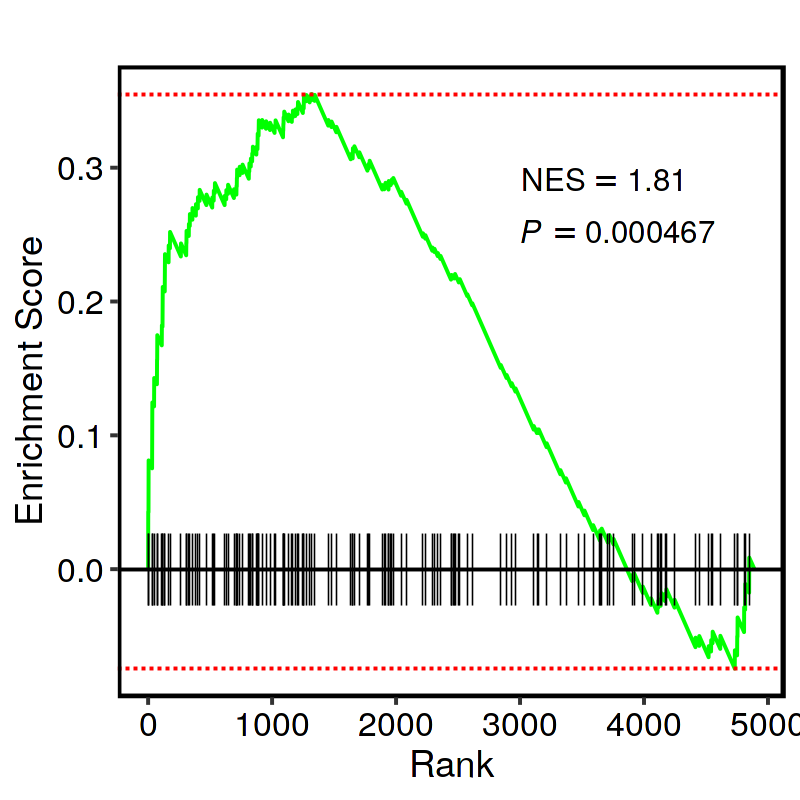

In [21]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res=200)
p1 <- plotEnrichment(pathways$NeoTCR8, ranks) + 
    ggtitle('') + 
    ylab('Enrichment Score') + xlab('Rank') + theme_scp() +  
    theme(
        panel.grid.major = element_blank(),
        plot.title = element_text(hjust = 0.5, size = 13)
      )
padj <- signif(fgseaRes$padj[fgseaRes$pathway == "NeoTCR8"], 3)
p1 <- p1 + annotate("text", x = 3000, y = 0.3,  #  x = 5200, y = 0.28, x = 4000, y = -0.2, x = 2500, y = 0.32, 
    label = sprintf('atop(NES == %.2f * phantom("..."), italic(P) == %.2e * phantom(""))', fgseaRes$NES, padj),
    hjust = 0, vjust = 1, parse = TRUE)
print(p1)


In [24]:
pdf(file.path(panel.path, paste0("GSEA: NeoTCR8 gene set in CD8+ CART vs Endogenous.pdf")), width=3.5, height=3.5)
p1
dev.off()

pdf 
  2